# Breast Cancer Ultrasound Image Segmentation With Attention U-Net

Author: **Marcin Sikorski**<br>
Date: August, 2024

**Introduction & Motivation**<br>
Breast cancer is one of the most common cause of death among women worldwide. Early detecting significantly helps in reducing the consequences and number of deaths. Breast ultrasound images are basic data sources for medical staff to detect cancer tissue and prevent early death. These sonograms can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

In order to achieve efficient and accurate breast tumor recognition and diagnosis, this notebook proposes a breast tumor ultrasound image segmentation method based on Attention U-Net framework, a combination of U-Net and attention mechanism. The attention mechanism introduced into the image analysis model should improve the ability to obtain the feature information of ultrasound images and realize the accurate recognition and extraction of breast tumors.

**Notebook Content:**
1. Loading & Preprocessing Data
2. Visualizing Dataset
3. Attention U-Net vs. U-Net
4. Attention U-Net Evaluation
5. Conclusions

### 1. Loading & Preprocessing Data

At this step, we will load the data (ultrasound images and their corresponding masks). The data processed in this notebook origins from [Kaggle](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset). The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. There are three classes in this dataset and each image has different shape. The following distribution for each of the three classes:
* benign - 892 files,
* malignant - 421 files,
* normal - 266 files.

We will start with unzipping the data into a new directory and explore its contents.

In [1]:
import zipfile
import os

# unzip data
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [2]:
import os

# check classes
# 0: normal
# 1: benign
# 2: malignant
directories = 'Dataset_BUSI_with_GT/'

unique_classes = []
for path in os.listdir(directories):
    unique_classes.append(path)
    
print('Unique classes:\n', unique_classes)

Unique classes:
 ['benign', 'malignant', 'normal']


The following code will extract mask metadata. We want to extract the shape of images. A function will detect the contours of tumors and return its widths and heights in pixels. This tabular result is not necessary for further analysis.

In [3]:
import cv2
from pandas import DataFrame

def bounding_box_img(filepath):
    img = cv2.imread(filepath)
    height, width, channels = img.shape
    
    # detect metastasis contours: xmin, ymin, width, height
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
    return (height, width, channels, x, y, w, h)

def extract_label(filepath):
    if 'benign' in filepath:
        return 'benign'
    else:
        return 'malignant'

# dictionary for storing metadata
dict_img = {'filename': [], 'img height': [], 'img width': [], 'img channels': [],
            'xmin': [], 'ymin': [], 'width': [], 'height': [], 'label': []}

def extract_metadata(file_dir):
    masks = sorted(os.listdir(file_dir))
    for f in masks:
        if 'mask' in f:
            full_path = os.path.join(file_dir, f)
            height, width, channels, x, y, w, h = bounding_box_img(full_path)
            
            # skip if no bounding box was found
            if x is not None: 
                dict_img['filename'].append(f)
                dict_img['img height'].append(height)
                dict_img['img width'].append(width)
                dict_img['img channels'].append(channels)
                dict_img['xmin'].append(x)
                dict_img['ymin'].append(y)
                dict_img['width'].append(w)
                dict_img['height'].append(h)
                dict_img['label'].append(extract_label(f))

# run final function & generate dataframe
extract_metadata('Dataset_BUSI_with_GT/malignant/')
extract_metadata('Dataset_BUSI_with_GT/benign/')

df_img = DataFrame(dict_img)
df_img.head()

,filename,img height,img width,img channels,xmin,ymin,width,height,label
0,malignant (1)_mask.png,598,449,3,8,133,432,271,malignant
1,malignant (10)_mask.png,393,462,3,206,36,100,78,malignant
2,malignant (100)_mask.png,476,557,3,159,70,236,120,malignant
3,malignant (101)_mask.png,559,883,3,237,95,404,279,malignant
4,malignant (102)_mask.png,551,916,3,186,128,396,285,malignant


Some ultrasound images have assigned multiple masks: one tumor (metastasis) per mask. We want to generate new, single masks that contain multiple mask images (if they exist). These new overlayed masks will be then assigned to sonograms for semantic segmentation.

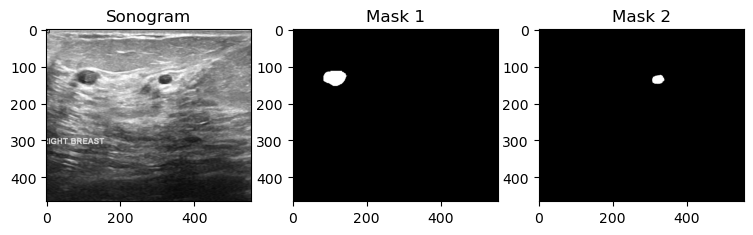

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# plot sonogram & masks
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

image = Image.open(r'Dataset_BUSI_with_GT\benign\benign (4).png')
axs[0].imshow(image)
axs[0].set(title='Sonogram')

image = Image.open(r'Dataset_BUSI_with_GT\benign\benign (4)_mask.png')
axs[1].imshow(image)
axs[1].set(title='Mask 1')

image = Image.open(r'Dataset_BUSI_with_GT\benign\benign (4)_mask_1.png')
axs[2].imshow(image)
axs[2].set(title='Mask 2')

plt.show()

In [5]:
from glob import glob

def generate_single_masks(label):
    # set directory containing the mask images
    directory = f'Dataset_BUSI_with_GT/{label}/'
    
    # get all the mask files in the directory
    mask_files = glob(os.path.join(directory, '*_mask*.png'))
    
    # function to extract the base name from the file path
    def get_base_name(filepath):
        filename = os.path.basename(filepath)
        base_name = filename.split('_mask')[0]
        return base_name
    
    # group files by their base names
    mask_groups = {}
    for mask in mask_files:
        base_name = get_base_name(mask)
        if base_name not in mask_groups:
            mask_groups[base_name] = []
        mask_groups[base_name].append(mask)
    
    # create overlayed masks
    for base_name, files in mask_groups.items():
        # initialize an empty variable for the mask
        overlayed_mask = None
    
        for file in files:
            # load each mask image
            mask = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    
            if overlayed_mask is None:
                overlayed_mask = mask
            else:
                # overlay the current mask onto the accumulated mask
                overlayed_mask = cv2.add(overlayed_mask, mask)
        
        # save the new mask
        output_filename = os.path.join(directory, f'{base_name}_overlayed.png')
        cv2.imwrite(output_filename, overlayed_mask)
        #print(f'Saved overlayed mask: {output_filename}')

# run function
generate_single_masks(label='benign')
generate_single_masks(label='malignant')
generate_single_masks(label='normal') # these have plain masks but we need them renamed

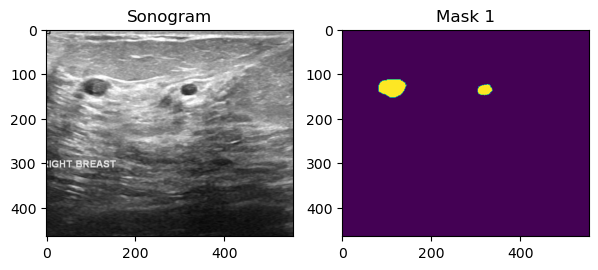

In [6]:
# check results
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

image = Image.open(r'Dataset_BUSI_with_GT\benign\benign (4).png')
axs[0].imshow(image)
axs[0].set(title='Sonogram')

image = Image.open(r'Dataset_BUSI_with_GT\benign\benign (4)_overlayed.png')
axs[1].imshow(image)
axs[1].set(title='Mask 1')

plt.show()

In [ ]:
# optional code for deleting 'overlayed' files
# directory from where to delete the files
directory = 'Dataset_BUSI_with_GT/benign/'

files_to_delete = glob(os.path.join(directory, '*overlayed*.png'))

# delete each file
for file in files_to_delete:
    try:
        os.remove(file)
        #print(f'Deleted: {file_path}')
    except OSError as e:
        print(f'Error deleting {file}: {e}')

The following function loads each file (image or mask) as a NumPy array and reshapes it to a unified 256 x 256 resolution. The function normalizes the arrays.

The converted images will be then stacked into two separate lists: images and masks. Finally, the lists of arrays will be divided into train and validation subsets with 80:20 ratio.

In [7]:
from tensorflow.image import resize
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# load images & convert to NumPy arrays
def load_images(image_paths, img_size=256, mask=False):
    # mask: 1 channel
    # image: 3 channels
    if mask:
        images = np.zeros(shape=(len(image_paths), img_size, img_size, 1))
    else:
        images = np.zeros(shape=(len(image_paths), img_size, img_size, 3))
    
    for i, image in enumerate(image_paths):
        img = np.round(resize(img_to_array(load_img(image))/255., (img_size, img_size)), 4)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    
    return images

In [8]:
root_path = r'Dataset_BUSI_with_GT/'
unique_classes = ['benign', 'malignant', 'normal']

# set sorted paths into list
sorted_mask_paths = sorted([sorted(glob(root_path + name + '/*overlayed.png')) for name in unique_classes])

image_paths = []
mask_paths = []
for class_path in sorted_mask_paths:
    for path in class_path:
        img_path = path.replace('_overlayed', '')
        image_paths.append(img_path)
        mask_paths.append(path)

# convert images & masks
images = load_images(image_paths, img_size=256)
masks = load_images(mask_paths, img_size=256, mask=True)

print('Number of samples:', len(images))
print('Image shape:', images[0].shape, ', Mask shape:', masks[0].shape)

Number of samples: 780
Image shape: (256, 256, 3) , Mask shape: (256, 256, 1)


In [9]:
from sklearn.model_selection import train_test_split

# split dataset into 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.20, random_state=42)

print('Training samples:', len(X_train))
print('Testing samples:', len(X_test))

Training samples: 624
Testing samples: 156


### 2. Visualizing Dataset

A few samples of the images and their masks will be plotted.

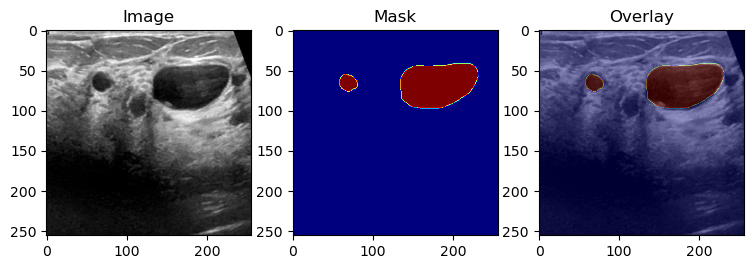

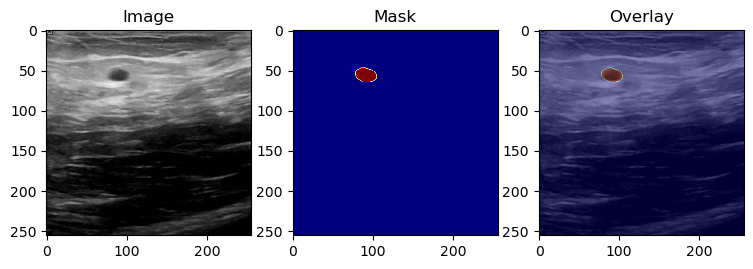

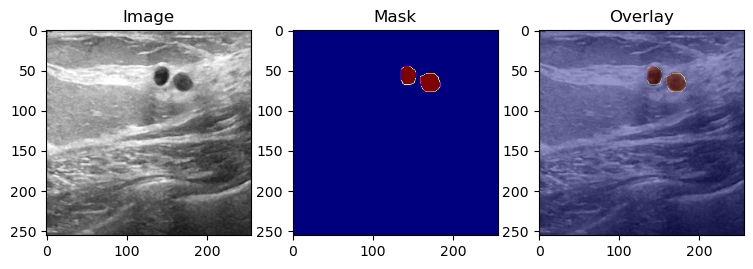

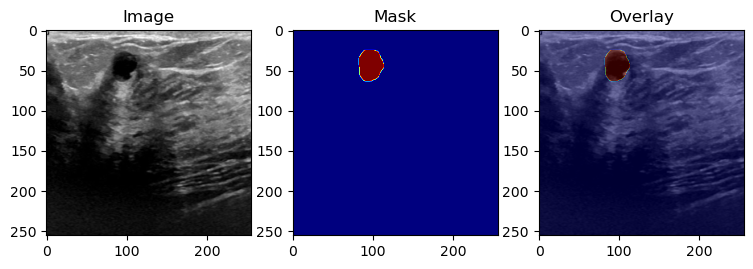

In [10]:
def visualize_dataset(idx):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    
    axs[0].imshow(images[idx])
    axs[0].set(title='Image')
    
    axs[1].imshow(masks[idx], cmap='jet')
    axs[1].set(title='Mask')
    
    axs[2].imshow(images[idx])
    axs[2].imshow(masks[idx], cmap='jet', alpha=0.4)
    axs[2].set(title='Overlay')
    
    plt.show()

for i in [387, 52, 167, 32]:
    visualize_dataset(idx=i)

### 3. Attention U-Net vs. U-Net

The Attention U-Net is an extension of U-Net that incorporates attention mechanisms to better focus on the important regions and features of the input image. These attention mechanisms (set as attention gates) help the neural network to learn more fine-grained features and improve the overall segmentation performance. They increase the weight of the target area and suppress the background area irrelevant to the segmentation task. Attention gates for medical imaging automatically learn to focus on tumor structures of varying shapes and sizes proposed to eliminate the necessity of using explicit external tissue/organ localisation modules of cascaded convolutional neural networks, thus improving the model sensitivity and accuracy to foreground pixels without significant computation overhead.

We will define attention gates, encoder and decoder blocks as classes (objects). The entire network architecture will be built from these blocks and trained for 25 epochs. Since we need to distinguish the cancer tissue from the healthy tissue in the imagery, the loss function will be binary cross-entropy.

In [11]:
from tensorflow.keras.layers import Layer, Input, Conv2D, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Add, Multiply, BatchNormalization
from tensorflow.keras.models import Model

# define encoder
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = None
        self.drop = None
        self.c2 = None
        self.pool = None if not pooling else MaxPool2D()

    def build(self, input_shape):
        self.c1 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        
        super(EncoderBlock, self).build(input_shape)

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 'filters': self.filters,
            'rate': self.rate, 'pooling': self.pooling
        }

# define decoder
class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'filters': self.filters, 'rate': self.rate}
        
# define attention gate
class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'filters': self.filters, 'bn': self.bn}

In [12]:
def attention_unet_mod(img_height=256, img_width=256, img_channels=3):
    # input layer
    inputs = Input(shape=(img_height, img_width, img_channels))
    
    # encoder block
    p1, c1 = EncoderBlock(32, rate=0.1, name='Encoder_1')(inputs)
    p2, c2 = EncoderBlock(64, rate=0.1, name='Encoder_2')(p1)
    p3, c3 = EncoderBlock(128, rate=0.2, name='Encoder_3')(p2)
    p4, c4 = EncoderBlock(256, rate=0.2, name='Encoder_4')(p3)
    
    # encoding
    encoding = EncoderBlock(512, 0.3, pooling=False, name='Encoding')(p4)
    
    # attention gate + decoder block
    a1 = AttentionGate(256, bn=True, name='Attention_1')([encoding, c4])
    d1 = DecoderBlock(256, rate=0.2, name='Decoder_1')([encoding, a1])
    
    a2 = AttentionGate(128, bn=True, name='Attention_2')([d1, c3])
    d2 = DecoderBlock(128, rate=0.2, name='Decoder_2')([d1, a2])
    
    a3 = AttentionGate(64, bn=True, name='Attention_3')([d2, c2])
    d3 = DecoderBlock(64, rate=0.1, name='Decoder_3')([d2, a3])
    
    a4 = AttentionGate(32, bn=True, name='Attention_4')([d3, c1])
    d4 = DecoderBlock(32, rate=0.1, name='Decoder_4')([d3, a4])

    # output layer
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)
    
    model = Model(inputs=[inputs], outputs=[outputs], name='Attention_U-Net')
    return model

att_model = attention_unet_mod()
att_model.summary()

Model: "Attention_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Encoder_1 (EncoderBlock)      │ [(None, 128, 128, 32),    │          10,144 │ input_layer_1[0][0]        │
│                               │ (None, 256, 256, 32)]     │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Encoder_2 (EncoderBlock)      │ [(None, 64, 64, 64),      │          55,424 │ Encoder_1[0][0]            │
│                               │ (None, 128, 128, 64)]     │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Encoder_3 (EncoderBlock)      │ [(None, 32, 32, 128),     │         221,440 │ Encoder_2[0][0]            │
│                               │ (None, 64, 64, 128)]      │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Encoder_4 (EncoderBlock)      │ [(None, 16, 16, 256),     │         885,248 │ Encoder_3[0][0]            │
│                               │ (None, 32, 32, 256)]      │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Encoding (EncoderBlock)       │ (None, 16, 16, 512)       │       3,539,968 │ Encoder_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Attention_1 (AttentionGate)   │ (None, 32, 32, 256)       │       1,771,265 │ Encoding[0][0],            │
│                               │                           │                 │ Encoder_4[0][1]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Decoder_1 (DecoderBlock)      │ (None, 32, 32, 256)       │       2,359,808 │ Encoding[0][0],            │
│                               │                           │                 │ Attention_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Attention_2 (AttentionGate)   │ (None, 64, 64, 128)       │         443,265 │ Decoder_1[0][0],           │
│                               │                           │                 │ Encoder_3[0][1]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Decoder_2 (DecoderBlock)      │ (None, 64, 64, 128)       │         590,080 │ Decoder_1[0][0],           │
│                               │                           │                 │ Attention_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Attention_3 (AttentionGate)   │ (None, 128, 128, 64)      │         111,041 │ Decoder_2[0][0],           │
│                               │                           │                 │ Encoder_2[0][1]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Decoder_3 (DecoderBlock)      │ (None, 128, 128, 64)      │         147,584 │ Decoder_2[0][0],           │
│                               │                           │                 │ Attention_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 10,200,101 (38.91 MB)

 Trainable params: 10,199,141 (38.91 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

# compile Attention U-Net model
att_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001, name='adam'),
    metrics=[MeanIoU(num_classes=2, name='IoU'), 'accuracy']
)

# define callbacks
csv_logger = CSVLogger('att_unet_history.txt', append=True, separator=',')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=7,
    mode='auto',
    verbose=1,
    restore_best_weights=True
)

# network training
history = att_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=8,
    verbose=1,
    callbacks=[csv_logger, earlystop]
)

Epoch 1/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 807s 10s/step - IoU: 0.4601 - accuracy: 0.8978 - loss: 19.1509 - val_IoU: 0.4622 - val_accuracy: 0.9223 - val_loss: 0.4011
Epoch 2/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 797s 10s/step - IoU: 0.4623 - accuracy: 0.9227 - loss: 0.2323 - val_IoU: 0.4622 - val_accuracy: 0.9223 - val_loss: 0.2420
Epoch 3/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 717s 9s/step - IoU: 0.4635 - accuracy: 0.9263 - loss: 0.2125 - val_IoU: 0.4622 - val_accuracy: 0.9225 - val_loss: 0.2258
Epoch 4/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 879s 11s/step - IoU: 0.4623 - accuracy: 0.9343 - loss: 0.1864 - val_IoU: 0.4622 - val_accuracy: 0.9246 - val_loss: 0.2294
Epoch 5/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 816s 10s/step - IoU: 0.4558 - accuracy: 0.9299 - loss: 0.1930 - val_IoU: 0.4622 - val_accuracy: 0.9254 - val_loss: 0.2142
Epoch 6/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 921s 12s/step - IoU: 0.4601 - accuracy: 0.9390 - loss: 0.1681 - val_IoU: 0.4622 - val_accuracy: 0.9381 - val_loss: 0.1804
Epoch 7/25
78/78 ━━━━━━━━━━━━━━━━━━━━ 86

In [14]:
# save model
att_model.save('attention_unet_mod.keras')

# display training results
df_results = DataFrame(history.history)
df_results.round(4)

,IoU,accuracy,loss,val_IoU,val_accuracy,val_loss
0,0.4612,0.9139,5.1117,0.4622,0.9223,0.4011
1,0.4612,0.9212,0.2280,0.4622,0.9223,0.2420
2,0.4612,0.9245,0.2116,0.4622,0.9225,0.2258
3,0.4612,0.9330,0.1912,0.4622,0.9246,0.2294
4,0.4612,0.9386,0.1733,0.4622,0.9254,0.2142
5,0.4612,0.9419,0.1649,0.4622,0.9381,0.1804
6,0.4613,0.9437,0.1585,0.4622,0.9276,0.2038
7,0.4612,0.9426,0.1639,0.4622,0.9422,0.1664
8,0.4612,0.9474,0.1507,0.4622,0.9345,0.2043
9,0.4614,0.9486,0.1437,0.4622,0.9493,0.1525


### 4. Attention U-Net Evaluation

The model has been trained and its performance will be evaluated. We will plot the learning curves to get an overall review of the learning process. Next, we will perform sample predictions.

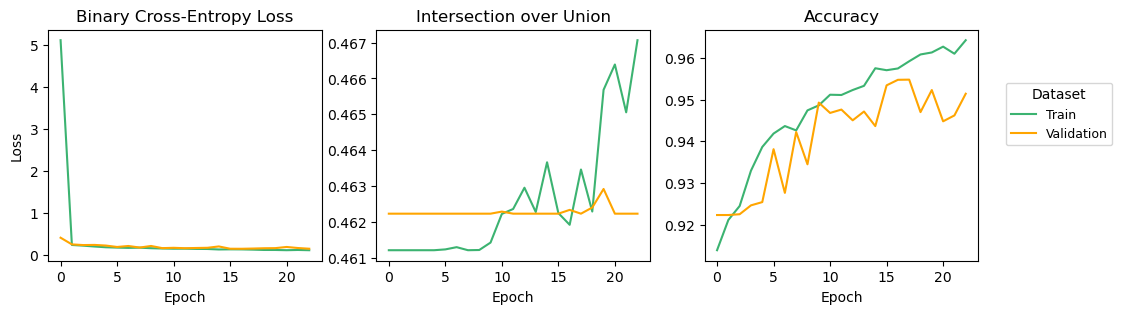

In [15]:
# plot learning curves
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(history.history['loss'], color='mediumseagreen', label='Train')
ax[0].plot(history.history['val_loss'], color='orange', label='Validation')
ax[0].set(title='Binary Cross-Entropy Loss', xlabel='Epoch', ylabel='Loss')

ax[1].plot(history.history['IoU'], color='mediumseagreen', label='Train')
ax[1].plot(history.history['val_IoU'], color='orange', label='Validation')
ax[1].set(title='Intersection over Union', xlabel='Epoch', ylabel=None)

ax[2].plot(history.history['accuracy'], color='mediumseagreen', label='Train')
ax[2].plot(history.history['val_accuracy'], color='orange', label='Validation')
ax[2].set(title='Accuracy', xlabel='Epoch', ylabel=None)
ax[2].legend(loc=(1.1, 0.5), prop={'size': 9}, title='Dataset')

plt.show()

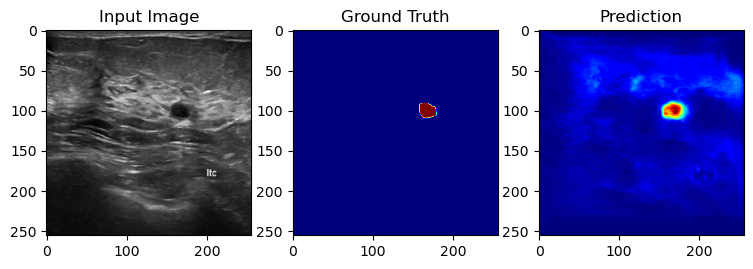

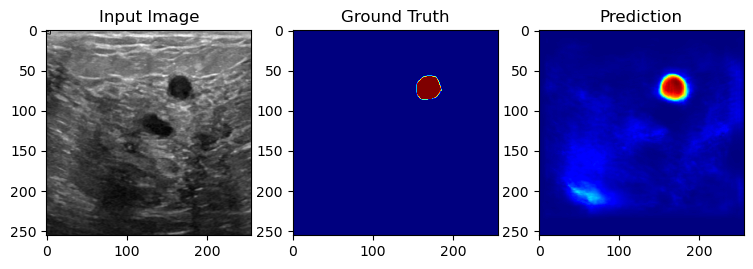

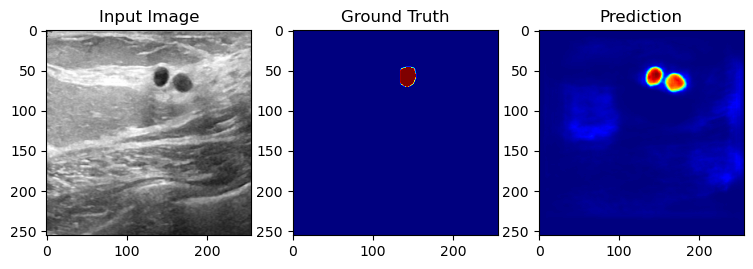

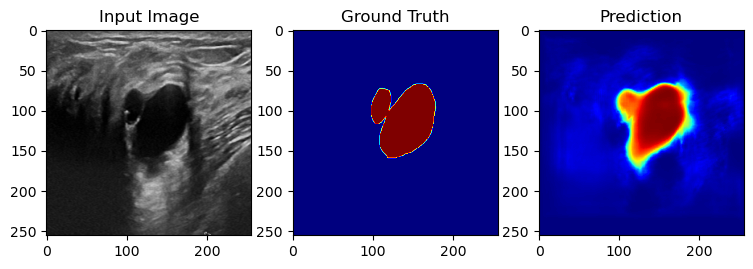

In [16]:
from random import randint

# predict new mask & plot results
def generate_plot():
    # get random image index
    rand_number = randint(0, 150)
    image = images[rand_number]
    mask = masks[rand_number]
    
    # make prediction
    prediction = att_model.predict(image[np.newaxis, ...], verbose=0)
    
    # plot: input, mask, prediction
    fig, axs = plt.subplots(1, 3, figsize=(9, 4))
    
    axs[0].imshow(image)
    axs[0].set(title='Input Image')
    
    axs[1].imshow(mask, cmap='jet')
    axs[1].set(title='Ground Truth')
    
    axs[2].imshow(np.squeeze(prediction), cmap='jet')
    axs[2].set(title='Prediction')
    
    plt.show()

# perform predictions
for _ in range(0, 4):
    generate_plot()

The segmentation network's learning curves display proper learning process. These sample predictions look accurate compared to their masks. The Attention U-Net network segments the cancer tissue correctly.

### 5. Conclusions

A breast tumor ultrasound image segmentation method based on Attention U-Net network was proposed. The U-Net network model is improved by introducing attention gates to upgrade the ability to obtain the feature information of sonograms and detect tumor structures within the tissue. The experimental results show that the proposed model can perform the analysis and determine cancer within ultrasound images. This method can provide reliable medical diagnosis assistance for physicians.

**References:**
* T. Zhao, H. Dai, 2022, *Breast Tumor Ultrasound Image Segmentation Method Based on Improved Residual U-Net Network*, [Full Text](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9252688/)
* https://kaggle.com/code/utkarshsaxenadn/breast-cancer-image-segmentation-attention-unet [Accessed: 29.08.2024]
* https://jinglescode.github.io/2019/12/08/biomedical-image-segmentation-u-net-attention/ [Accessed: 29.08.2024]
* https://sh-tsang.medium.com/review-attention-u-net-learning-where-to-look-for-the-pancreas-biomedical-image-segmentation-e5f4699daf9f [Accessed: 29.08.2024]
* https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831 [Accessed: 29.08.2024]